In [1]:
import sys, os
if os.path.exists("/home/cb2714/wwa/wwa.py"): 
     sys.path.append('/home/cb2714/wwa/')
else:
     sys.path.append('/rds/general/user/cb2714/home/wwa/')
from wwa import *

mapproj = cartopy.crs.PlateCarree()
xn,xx,yn,yx = [-10,4,35,44.5]

adm1 = gpd.read_file("sf_adm1/").to_crs(mapproj).clip(main_polygon(regionmask.defined_regions.natural_earth_v5_0_0.countries_50.to_geodataframe().set_index("names").loc[["Spain"]].set_crs(mapproj))).set_index("id")

warnings.filterwarnings("ignore", category = FutureWarning)

- Get time series & compare seasonal cycles & accumulations: Malaga; Madrid & Castilla la Mancha; Extremadura (maybe also southern Portugal?)

Maybe Murcia - there was flooding reported but it may be climatologically quite different

# Compile observational data

In [ ]:
eobs = wrap_lon(xr.open_dataset("/rds/general/user/cb2714/home/99_ephemera/eobs_rr.nc")).rr.rename("pr", longitude = "lon", latitude = "lat")
eobs = eobs.sel(lon = slice(xn,xx), lat = slice(yn,yx))
eobs.to_netcdf("data/ip_eobs-gridded.nc")

In [ ]:
era5 = wrap_lon(xr.open_dataset("/rds/general/user/cb2714/home/99_ephemera/era5_tp_daily_eu_extended_-10-4E_35-44.5N.nc")).tp.rename("pr")
era5.to_netcdf("data/ip_era5-gridded.nc")

In [ ]:
outpath = /rds/general/user/cb2714/home/99_ephemera/mswx/
for y in range(1979,2025):
    if os.path.exists(outpath+"mswx_"+str(y)+".nc"): continue
    
    ds = wrap_lon(xr.open_mfdataset("/rds/general/user/cb2714/home/00_WWA_project_folder/live/data/mswx/P/"+str(y)+"/*")).sel(lon = slice(xn,xx), lat = slice(yn,yx)).precipitation.rename("pr").load()
    rm = regionmask.defined_regions.natural_earth_v5_0_0.land_50.mask(ds)

    ds = ds.where(rm == 0)
    ds.to_netcdf(outpath+"mswx_"+str(y)+".nc")

ds = xr.open_mfdataset(outpath+"mswx_*.nc")
ds.to_netcdf("data/ip_mswx-gridded.nc")

In [ ]:
ds = wrap_lon(xr.open_mfdataset("/rds/general/user/cb2714/home/00_WWA_project_folder/live/data/chirps_05/*.nc")).precip
ds = ds.rename("pr", longitude = "lon", latitude = "lat").sel(lon = slice(xn,xx), lat = slice(yn,yx))
ds.to_netcdf("data/ip_chirps-gridded.nc")

# Shapefiles

In [2]:
spain = regionmask.defined_regions.natural_earth_v5_0_0.countries_50.to_geodataframe().set_index("names").loc[["Spain"]]
spain = main_polygon(spain)

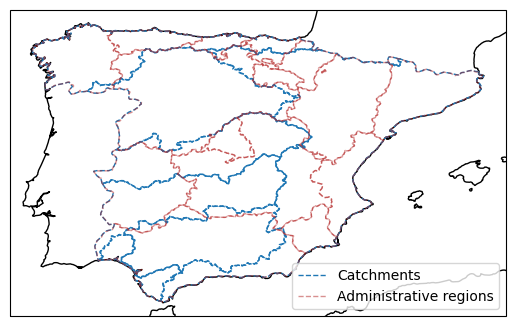

In [5]:
hybas04 = gpd.read_file("sf_hybas04/").to_crs(mapproj).clip(spain.set_crs(mapproj))

fig, ax = plt.subplots(subplot_kw = {"projection" : mapproj})

hybas04.boundary.plot(ax = ax, ls = "--", lw = 1, label = "Catchments")
adm1.boundary.plot(ax = ax, color = "firebrick", ls = "--", lw = 1, alpha = 0.5, label = "Administrative regions")
ax.coastlines(lw = 1)

ax.legend(loc = "lower right")

# Physical geography & climatology

In [6]:
elev = wrap_lon(xr.open_dataset("/rds/general/user/cb2714/home/00_WWA_project_folder/live/data/elev.0.25-deg.nc", decode_times = False)).squeeze(drop = True).data.sel(lon = slice(xn,xx), lat = slice(yn,yx))

# load Koppen-Geiger classificatins, group into broader categories
kg = xr.open_dataset("/rds/general/user/cb2714/home/00_WWA_project_folder/live/data/koppen-geiger/kg_classifications.nc").kg_cat.sel(lon = slice(xn,xx), lat = slice(yn,yx))
kg_grouped = xr.apply_ufunc(np.digitize, kg, kwargs={'bins': [0.5,3.5,7.5,16.5,28.5,30]})

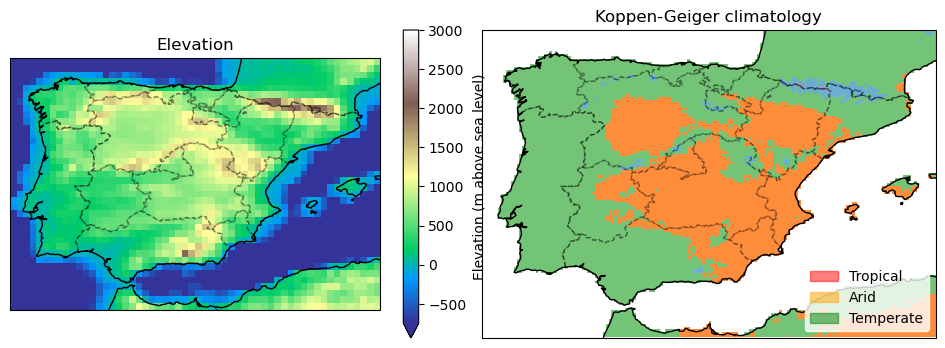

In [9]:
nr = 1; nc = 2
fig, axs = plt.subplots(ncols = nc, nrows = nr, figsize = (6*nc, 4*nr), dpi = 100, subplot_kw = {"projection" : mapproj, "extent" : (xn,xx,yn,yx)})
plt.subplots_adjust(wspace = 0.01)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
ax = axs[0]
elev.plot(ax = ax, cmap = "terrain", vmin = -750, vmax = 3000, cbar_kwargs = {"label" : "Elevation (m above sea level)"})
ax.set_title("Elevation")
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
ax = axs[1]
kg_grouped.where(kg_grouped == 1).plot(ax = ax, cmap = "Reds", add_colorbar = False)      # tropical
kg_grouped.where(kg_grouped == 2).plot(ax = ax, cmap = "Oranges", add_colorbar = False)   # arid
kg_grouped.where(kg_grouped == 3).plot(ax = ax, cmap = "Greens", add_colorbar = False)    # temperate
kg_grouped.where(kg_grouped == 4).plot(ax = ax, cmap = "Blues", add_colorbar = False)     # cold
kg_grouped.where(kg_grouped == 5).plot(ax = ax, cmap = "Purples", add_colorbar = False)   # polar

plt.legend(handles = [matplotlib.patches.Patch(color = "red", label = "Tropical", alpha = 0.5), 
                      matplotlib.patches.Patch(color = "orange", label = "Arid", alpha = 0.5), 
                      matplotlib.patches.Patch(color = "green", label = "Temperate", alpha = 0.5), 
#                       matplotlib.patches.Patch(color = "tab:blue", label = "Cold", alpha = 0.5),
#                       matplotlib.patches.Patch(color = "purple", label = "Polar", alpha = 0.3)
                     ], 
           edgecolor = "w", loc = "lower right")
ax.set_title("Koppen-Geiger climatology")
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

for ax in axs:
    ax.coastlines()
    ax.add_feature(cartopy.feature.BORDERS, color = "k", alpha = 0.5, ls = "--")
#     ax.add_feature(cartopy.feature.RIVERS, color = "blue", alpha = 0.5)
    adm1.boundary.plot(ax = ax, color = "k", ls = "--", alpha = 0.3, lw = 1)

plt.savefig("fig/physical-geography.png")

# Event maps (MSWEP)

In [13]:
ds = xr.open_dataset("data/mswx_2025.nc").pr

In [4]:
px = pd.DataFrame.from_dict({s : get_latlon(s) for s in ["Constantina, ES", "Anora", "Pujerra"]}).transpose()   # cities where fatalities were recorded

In [41]:
px_c1 = pd.DataFrame.from_dict({s : get_latlon(s) for s in ["Madrid", "Seville", "Valencia"]}).transpose()

In [40]:
px_c2 = pd.DataFrame.from_dict({s : get_latlon(s) for s in ["Malaga"]}).transpose()

In [42]:
px_c = pd.concat([px_c1, px_c2])

In [14]:
ds_w = ds.sel(time = slice("2025-03-17", "2025-03-22")).mean("time")
ds_m = ds.sel(time = "2025-03").mean("time")

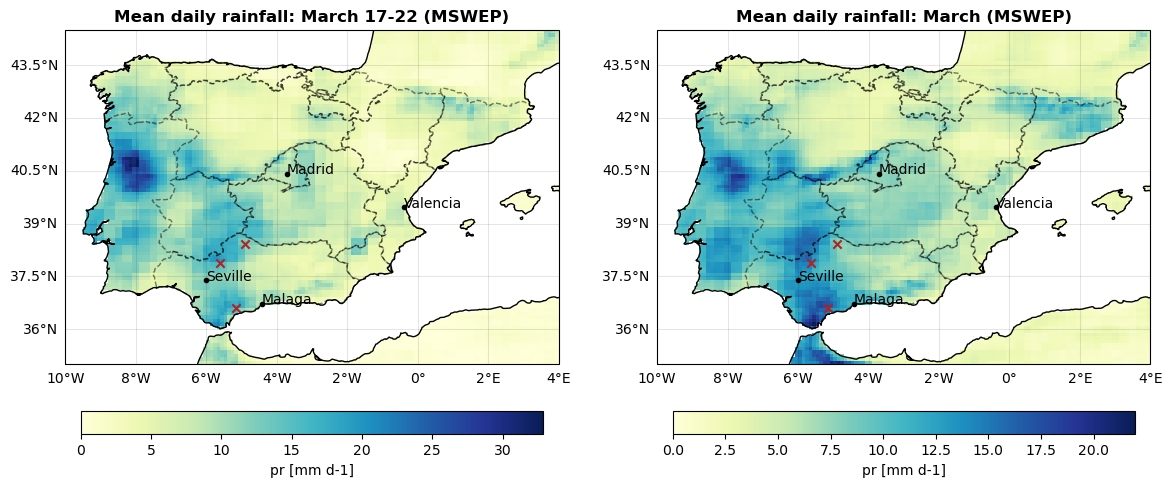

In [43]:
fig, axs = plt.subplots(ncols = 2, subplot_kw = {"projection" : mapproj}, figsize = (14,6))

for i in range(2):
    ax = axs[i]
    ds_i = [ds_w, ds_m][i]
    ttl = ["March 17-22", "March"][i]
    
    ds_i.plot(ax = ax, cmap = "YlGnBu", cbar_kwargs = {"location" : "bottom", "shrink" : 0.95, "fraction" : 0.05, "pad" : 0.1}, vmin = 0)
    
    adm1.boundary.plot(ax = ax, color = "k", alpha = 0.5, ls = "--", lw = 1)
    ax.coastlines()
    ax.set_title("Mean daily rainfall: "+ttl+" (MSWEP)", fontweight = "bold")
    ax.scatter(px.lon, px.lat, marker = "x", color = "firebrick")
    ax.gridlines(color = "k", alpha = 0.1, draw_labels = ["bottom", "left"])
    
    for c in px_c.index:
        ax.scatter(*px_c.loc[c], marker = ".", color = "k")
        ax.annotate(text = c, xy = (px_c.loc[c].lon, px_c.loc[c].lat), ha = "left")

Text(0.5, 0.98, 'Daily rainfall totals during March (MSWEP)')

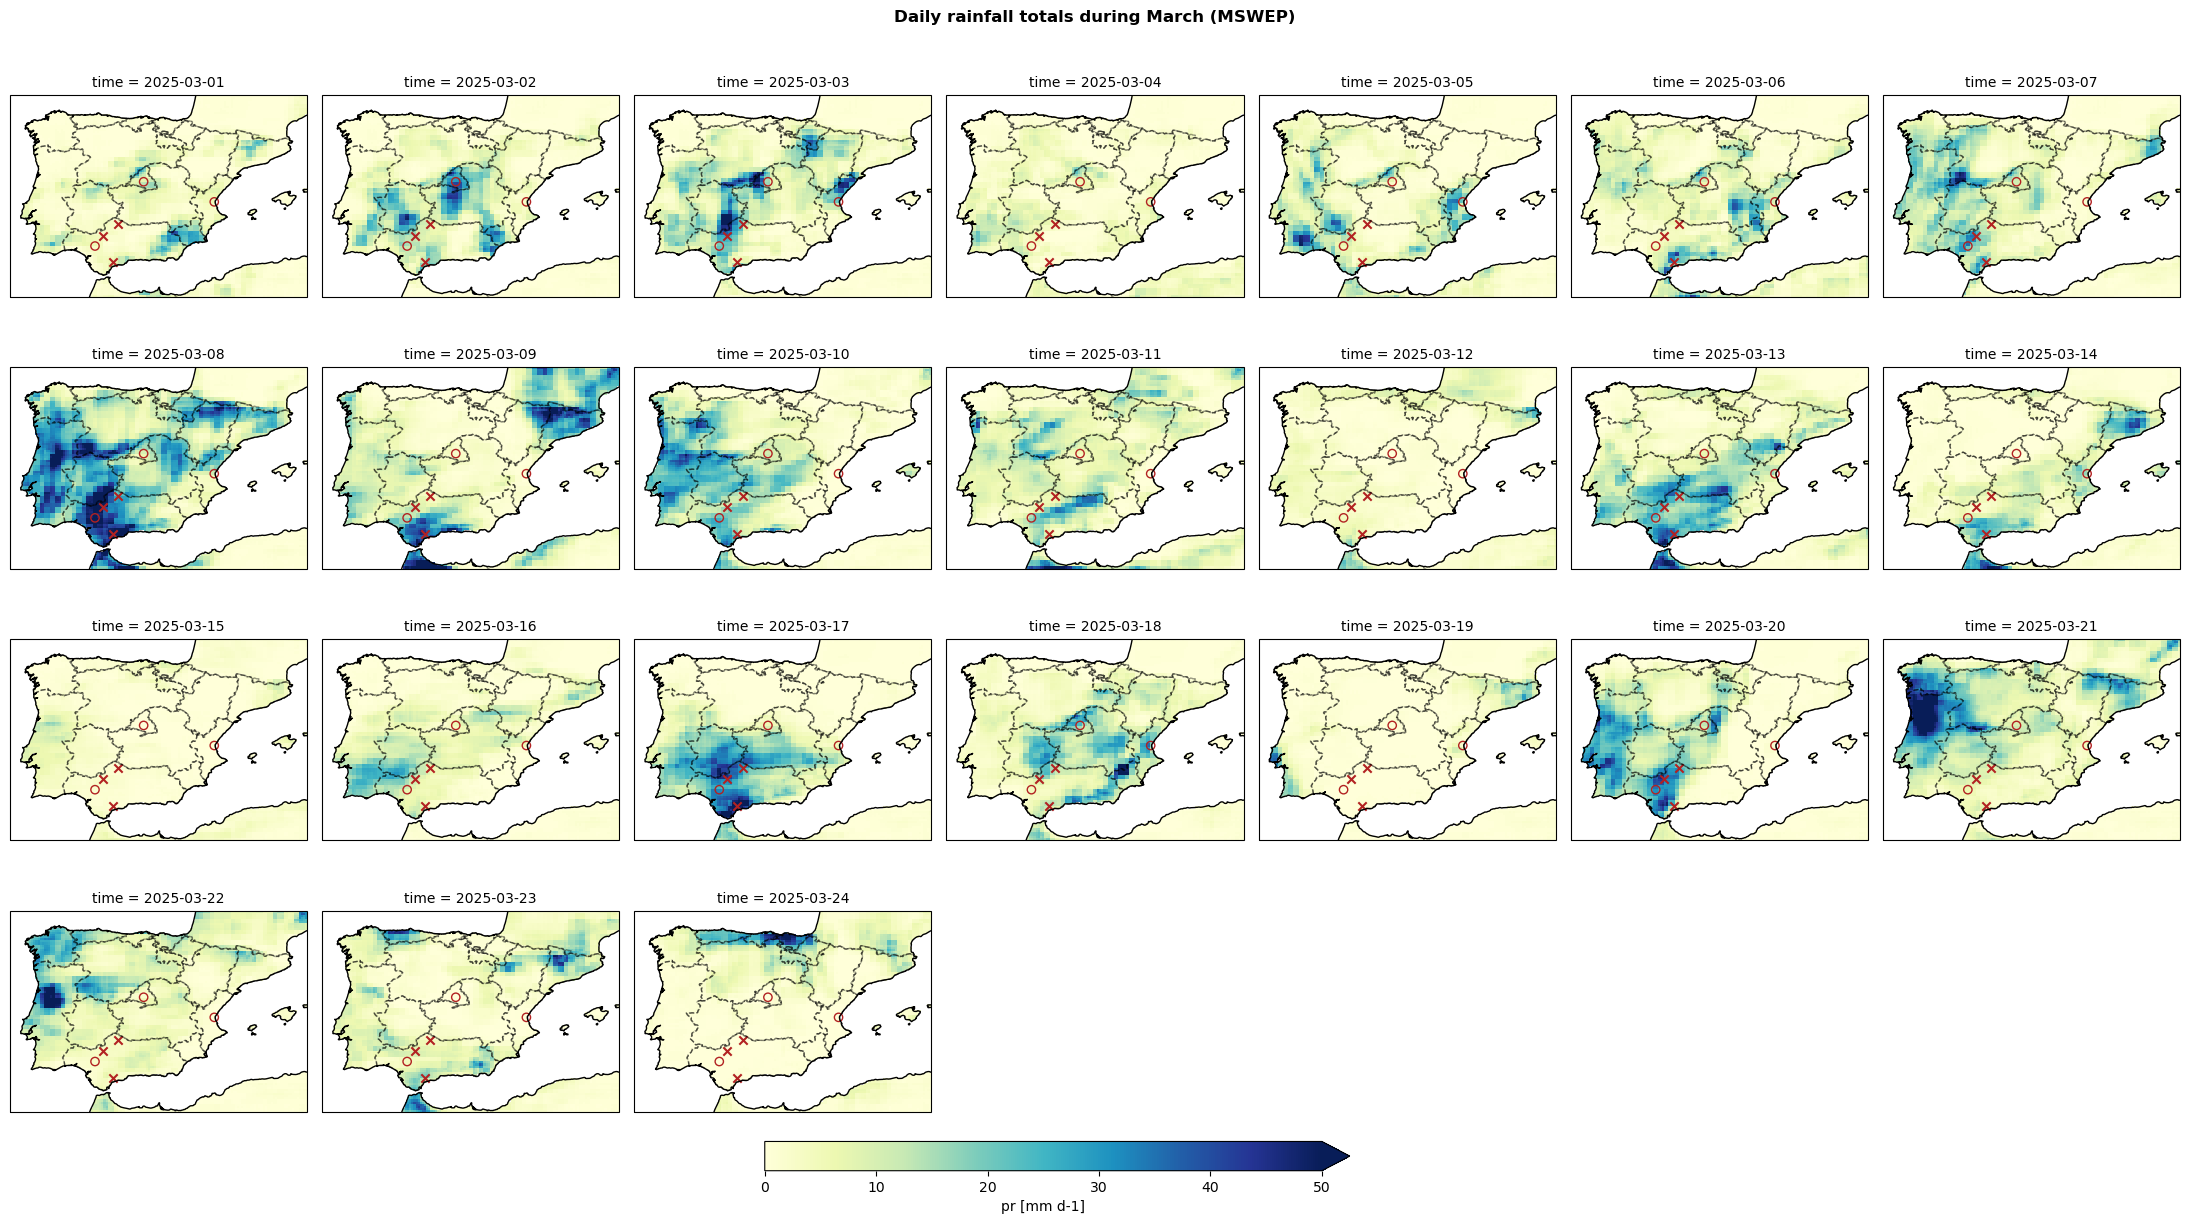

In [225]:
fig = ds.sel(time = "2025-03").plot(col = "time", col_wrap = 7, cmap = "YlGnBu", subplot_kws = {"projection" : mapproj, "extent" : [xn,xx,yn,yx]}, vmin = 0, vmax = 50,
                                   cbar_kwargs = {"location" : "bottom", "fraction" : 0.025, "pad" : 0.025})
axs = fig.axs.flatten()

for ax in axs:
    ax.coastlines()
    ax.add_feature(cartopy.feature.BORDERS, color = "k", ls = "--", alpha = 0.4)
    ax.scatter(px.lon, px.lat, marker = "x", color = "firebrick")
    ax.scatter(px_c.lon, px_c.lat, marker = "o", edgecolor = "firebrick", facecolor = "none")
#     adm1.loc[["ESAN"]].boundary.plot(ax = ax, color = "firebrick")
    adm1.boundary.plot(ax = ax, color = "k", alpha = 0.5, ls = "--", lw = 1)
    
plt.suptitle("Daily rainfall totals during March (MSWEP)", fontweight = "bold")

# Time series

In [26]:
regions = adm1.loc[["ESAN", "ESEX", "ESCM", "ESMD"]]
regions["n"] = range(4)

In [47]:
for ds_nm in ["mswx", "chirps", "era5", "eobs"]:
    
    ds = xr.open_dataset("data/ip_"+ds_nm+"-gridded.nc").pr
    rm = regionmask.mask_3D_geopandas(regions, ds.lon, ds.lat, numbers = "n")
    ts = ds.where(rm).mean(["lat", "lon"]).assign_coords(region = ("region", regions.index))
    ts.to_netcdf("data/ts-regional_"+ds_nm+".nc")